In [5]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf


In [6]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


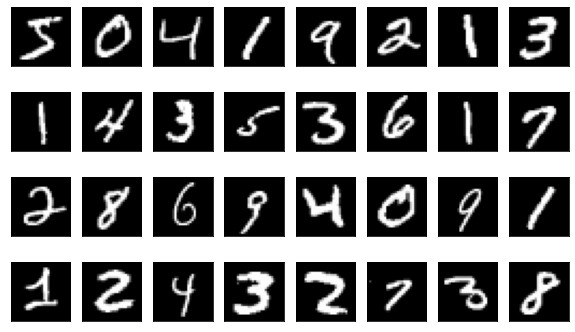

In [7]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_some_samples(train_x[:32, ...])

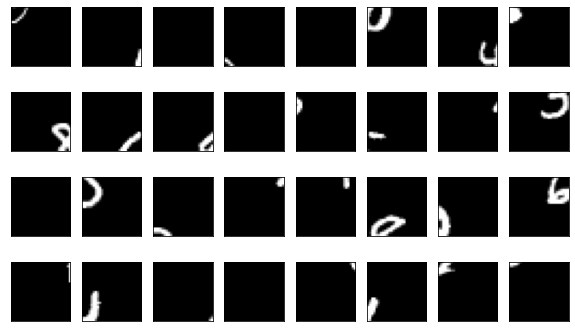

In [8]:
bg_samples = 100000 # Количество обучающих образцов из класса "фон"

bg_train_x = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
bg_train_y = np.ones((bg_samples,), dtype=np.int32)*10 

src_idxs = random.choices(range(train_x.shape[0]), k=bg_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    bg_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(bg_train_x[:32, ...])

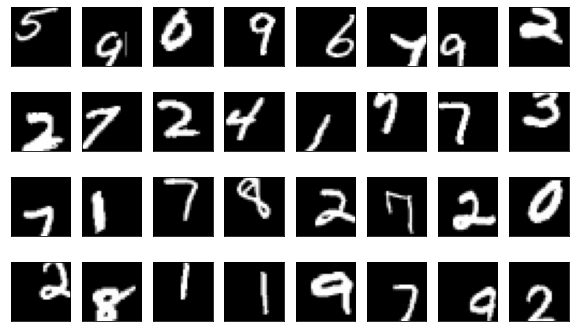

In [9]:
sh_samples = 50000 # Количество дополнительно сгенерированных образов для цифр (со смещениями)

sh_train_x = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
sh_train_y = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(train_x.shape[0]), sh_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    sh_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    sh_train_y[i] = train_y[src_idxs[i]]

plot_some_samples(sh_train_x[:32, ...])

In [10]:
train_x = np.concatenate((train_x, bg_train_x, sh_train_x), axis=0)
train_y = np.concatenate((train_y, bg_train_y, sh_train_y), axis=0)

In [11]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


In [13]:
model.fit(train_x, train_y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
3282/3282 [==============================] - 27s 5ms/step - loss: 0.1195 - accuracy: 0.9637
Epoch 2/3
3282/3282 [==============================] - 14s 4ms/step - loss: 0.0423 - accuracy: 0.9862
Epoch 3/3
3282/3282 [==============================] - 14s 4ms/step - loss: 0.0289 - accuracy: 0.9904


In [15]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 0.0262 - accuracy: 0.9924


[0.026211632415652275, 0.9923999905586243]

Слабая локализация с помошью FCN

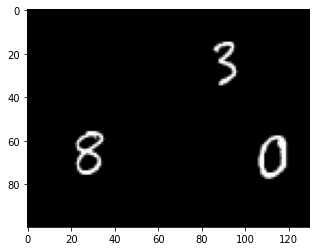

In [17]:
if True: # Сгенерировать случайное изображение
    
    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = test_x[random.randint(0, test_x.shape[0])]
        img = add_digit(img, digit)
    
else: # Загрузить готовое изображение 'digits.png'
    
    INPUT_IMAGE_FPTAH = '6.5_digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)
    
# Превращение входной картинки в RGB 
# (для визуализации и последующего смешивания с цветной тепловой картой)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

In [20]:
model_fcn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    #теперь вместо векторизации и полносвязных слоев используем подход fcn
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', padding='valid'),
    tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax', padding='valid')
])

model_fcn.build((None, None, None, 1))  #мы ее лоцируем, а не обучаем и передаем размер входа(размер не важен картинки т.к. у нас fcn не чувствительна) и 1 входной канал

Хотим скопировать данные из одной нейронной сети в другую
Сначал посмотрим списки слоёв

In [22]:
for idx, layer in enumerate(model.layers):
  print('{} => {}'.format(idx, layer))

0 => <keras.layers.convolutional.Conv2D object at 0x7f528cc09090>
1 => <keras.layers.pooling.MaxPooling2D object at 0x7f528cc024d0>
2 => <keras.layers.convolutional.Conv2D object at 0x7f528cc02b50>
3 => <keras.layers.pooling.MaxPooling2D object at 0x7f528cbeab10>
4 => <keras.layers.core.flatten.Flatten object at 0x7f528cbeae10>
5 => <keras.layers.core.dense.Dense object at 0x7f528cbeadd0>
6 => <keras.layers.core.dense.Dense object at 0x7f528cbead50>


In [21]:
for idx, layer in enumerate(model_fcn.layers):
  print('{} => {}'.format(idx, layer))

0 => <keras.layers.convolutional.Conv2D object at 0x7f528c55cbd0>
1 => <keras.layers.pooling.MaxPooling2D object at 0x7f528f96e1d0>
2 => <keras.layers.convolutional.Conv2D object at 0x7f528f97fc50>
3 => <keras.layers.pooling.MaxPooling2D object at 0x7f528f83bf50>
4 => <keras.layers.convolutional.Conv2D object at 0x7f528f96cc90>
5 => <keras.layers.convolutional.Conv2D object at 0x7f528f96ced0>


# Конвертация нам нужна, когда мы заранее обученную нейронну сеть хотим использовать для локализации

Копирование параметров из исходной сети

In [29]:
#пулинг слои копировать не надо, т.к. они не содержат никаких параметров

model_fcn.layers[0].kernel = model.layers[0].kernel
model_fcn.layers[0].bias = model.layers[0].bias
model_fcn.layers[2].kernel = model.layers[2].kernel
model_fcn.layers[2].bias = model.layers[2].bias
model_fcn.layers[4].kernel = tf.reshape(model.layers[5].kernel, (7, 7, 64, 256)) #делаем решэйп т.к. в полносвязном это двумерные матрицы, а в свёрточных слоях kernel это 4-х мерный тензор
model_fcn.layers[4].bias = model.layers[5].bias 
model_fcn.layers[5].kernel = tf.reshape(model.layers[6].kernel, (1, 1, 256, 11))
model_fcn.layers[5].bias = model.layers[6].bias

#7x7 потому что в сети 28 на 28 картинку пулинг слой в 4 раза уменьшил расширение картинки и нам уже на вход идет 7 на 7 и 64 нам приходят карт признаков и на входе другого нейрона знаем что должно быть 256

In [30]:
%%time

heatmaps = model_fcn.predict(img[None, ...])[0, ...]

CPU times: user 42.2 ms, sys: 0 ns, total: 42.2 ms
Wall time: 42.1 ms


In [31]:
from skimage.transform import resize

rec_field = (28, 28) # рецептивное поле FCN модели

# Сначала масштабируем тепловые карты       upscale
heatmaps = resize(heatmaps, (
        img.shape[0]-rec_field[0]+1, 
        img.shape[1]-rec_field[1]+1), 
    order=3, mode='reflect', anti_aliasing=True)

# Потом делаем паддинг
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)
heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

#если бы делали за один подход масштабирования то локализации бы съехали поэтому сначала до размеров 28 на 28 и потом добавляем паддинги

Визуализация тепловых карт для разных классов

Heatmap for class: 0


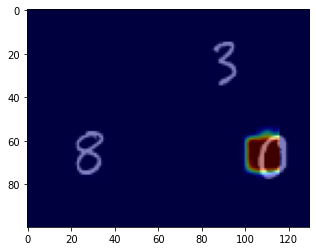

Heatmap for class: 1


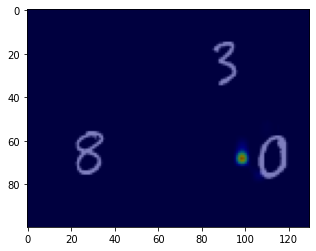

Heatmap for class: 2


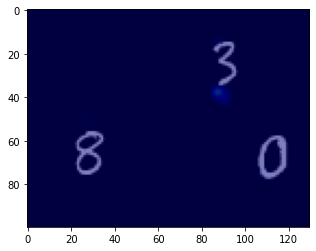

Heatmap for class: 3


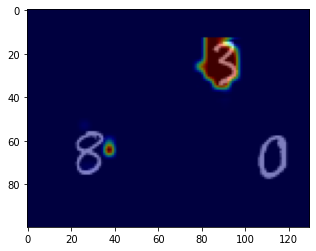

Heatmap for class: 4


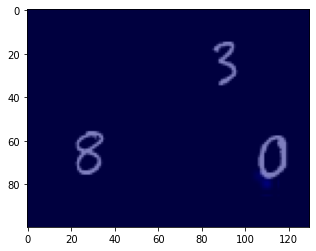

Heatmap for class: 5


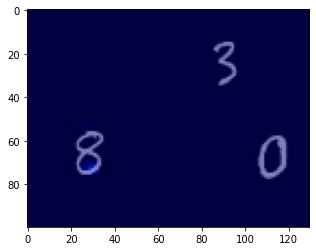

Heatmap for class: 6


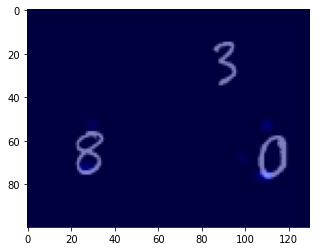

Heatmap for class: 7


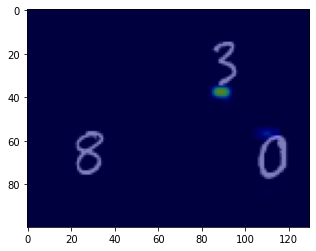

Heatmap for class: 8


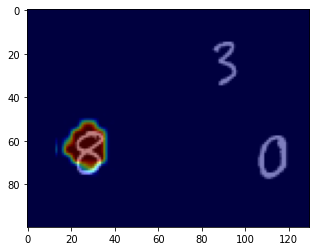

Heatmap for class: 9


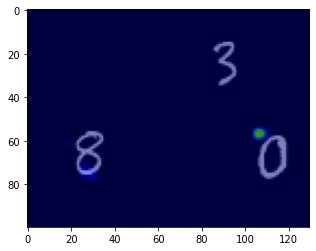

Heatmap for class: 10


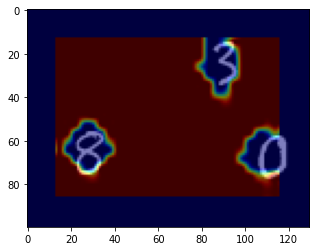

In [34]:
for clss in range(11):
  heatmap = heatmaps[..., clss]
  heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
  print('Heatmap for class:', clss)
  plt.imshow(img_clr*0.5 + heatmap_clr*0.5)
  plt.show()